In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
!pip install yfinance --upgrade --no-cache-dir

In [3]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/MyDrive/RP"

Mounted at /content/drive
/content/drive/MyDrive/RP


In [47]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
df = pdr.get_data_yahoo("LT.NS", start="2022-01-03").reset_index()
df.to_csv('/content/LT.csv',index=False)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,1895.000000,1937.449951,1893.650024,1922.849976,1894.265625,1906676
1,2022-01-04,1922.849976,1943.000000,1914.550049,1937.550049,1908.747192,1643920
2,2022-01-05,1940.699951,1951.000000,1927.650024,1948.599976,1919.632812,1711667
3,2022-01-06,1944.500000,1953.000000,1919.599976,1924.500000,1895.891113,1372015
4,2022-01-07,1929.050049,1934.949951,1897.150024,1904.900024,1876.582520,1447123


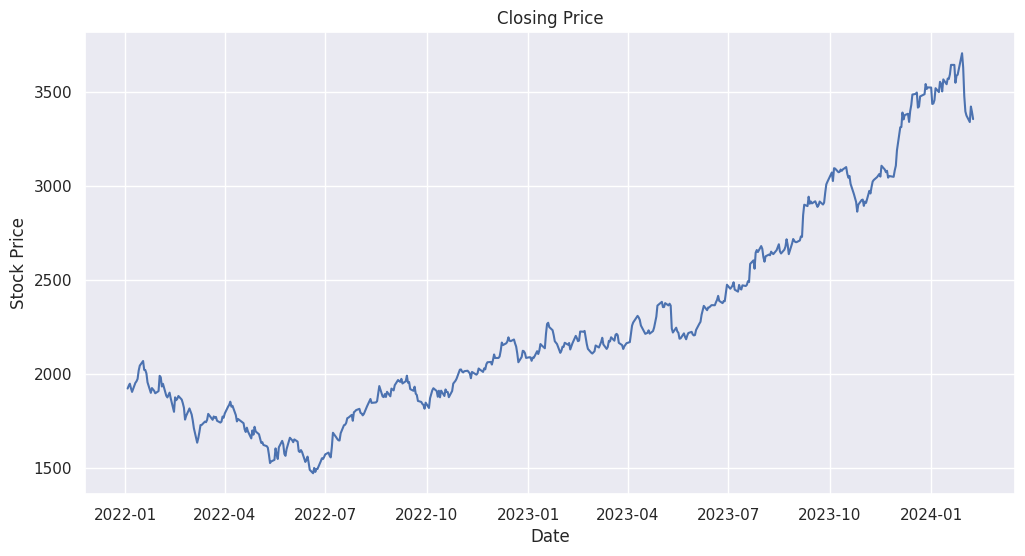

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

In [6]:
df = pd.read_csv('/content/LT.csv')

### Moving Average agent


In [7]:
import pandas as pd
import numpy as np

# Function to calculate moving averages and generate buy/sell signals
def apply_moving_average_strategy(df, short_window, long_window):
    signals = pd.DataFrame(index=df.index)
    signals['signal'] = 0.0

    signals['short_ma'] = df.rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_ma'] = df.rolling(window=long_window, min_periods=1, center=False).mean()

    signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:]
                                                > signals['long_ma'][short_window:], 1.0, 0.0)
    signals['positions'] = signals['signal'].diff().fillna(0)
    return signals

# Example usage:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))
signals = apply_moving_average_strategy(df['Close'], short_window, long_window)


In [8]:
# Function to execute buying and selling based on signals
def buy_stock(real_movement, signal, initial_money=10000, max_buy=1, max_sell=1):
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    for i in range(len(real_movement)):
        state = signal[i]
        if state == 1 and current_inventory == 0:
            shares = min(max_buy, initial_money // real_movement[i])
            initial_money -= shares * real_movement[i]
            current_inventory += shares
            states_buy.append(i)
            print(f"Day {i}: Buy {shares} units at price {shares * real_movement[i]}, total balance {initial_money}")
        elif state == -1 and current_inventory > 0:
            sell_units = min(max_sell, current_inventory)
            current_inventory -= sell_units
            total_sell = sell_units * real_movement[i]
            initial_money += total_sell
            states_sell.append(i)
            print(f"Day {i}: Sell {sell_units} units at price {total_sell}, total balance {initial_money}")

    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

states_buy, states_sell, total_gains, invest = buy_stock(df['Close'], signals['positions'])


Day 13: Buy 1 units at price 2003.5, total balance 7996.5
Day 23: Sell 1 units at price 1947.949951171875, total balance 9944.449951171875
Day 59: Buy 1 units at price 1773.5999755859375, total balance 8170.8499755859375
Day 75: Sell 1 units at price 1657.3499755859375, total balance 9828.199951171875
Day 103: Buy 1 units at price 1652.050048828125, total balance 8176.14990234375
Day 113: Sell 1 units at price 1489.949951171875, total balance 9666.099853515625
Day 129: Buy 1 units at price 1663.0, total balance 8003.099853515625
Day 182: Sell 1 units at price 1841.199951171875, total balance 9844.2998046875
Day 198: Buy 1 units at price 1904.1500244140625, total balance 7940.1497802734375
Day 249: Sell 1 units at price 2088.949951171875, total balance 10029.099731445312
Day 261: Buy 1 units at price 2273.10009765625, total balance 7755.9996337890625
Day 276: Sell 1 units at price 2163.85009765625, total balance 9919.849731445312
Day 286: Buy 1 units at price 2134.050048828125, total ba

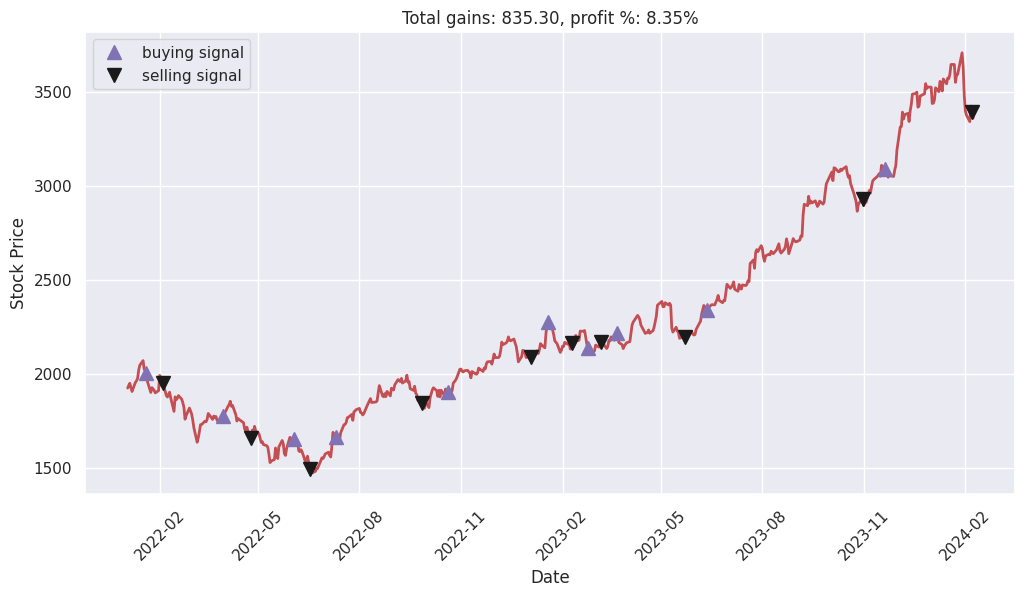

In [53]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/LT.csv')

# Extract date and close price
date = pd.to_datetime(df['Date'])
close = df['Close']

# Get the index of the first closing value
first_closing_index = close.first_valid_index()

# Extract the date and close price starting from the first closing value
date = date[first_closing_index:]
close = close[first_closing_index:]
plt.figure(figsize=(12, 6))
plt.plot(date, close, color='r', lw=2.)

# Plot markers for buying and selling signals
plt.plot(date[states_buy], close[states_buy], '^', markersize=10, color='m', label='buying signal')
plt.plot(date[states_sell], close[states_sell], 'v', markersize=10, color='k', label='selling signal')

plt.title('Total gains: %.2f, profit %%: %.2f%%' % (total_gains, invest))

# Set the locator for x-axis ticks to show dates every three months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()
